<a href="https://colab.research.google.com/github/Ankur-Soni14/AMEX_ProductTrack/blob/main/AMEX_Round2_batsmenandkeeperselection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, the required excel files are mounted using gdrive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


First, we create the qualified batsmen dataframe, using the cumulative runs criteria. We also create the 'Batting_Average' and 'Batting_Strike_Rate' coloumns which will be used later in the calculation of the cumulative score. 100s and 50s are calculated using the 'runs' coloumn.

In [ ]:
import pandas as pd

batsman_df = pd.read_excel('/content/gdrive/MyDrive/Amex Round 2/6671501a18c55_round2_input.xlsx', sheet_name=1)
bowler_df = pd.read_excel('/content/gdrive/MyDrive/Amex Round 2/6671501a18c55_round2_input.xlsx', sheet_name=2)
match_df = pd.read_excel('/content/gdrive/MyDrive/Amex Round 2/6671501a18c55_round2_input.xlsx', sheet_name=3)

# Calculate cumulative runs and merge with batsman_df
cumulative_runs = batsman_df.groupby('batsman_id')['runs'].sum().reset_index()
cumulative_runs.columns = ['batsman_id', 'cumulative_runs']
batsman_df = batsman_df.merge(cumulative_runs, on='batsman_id') # Merge cumulative runs into batsman_df

# Calculate average for all batsmen in batsman_df
avg = batsman_df.groupby('batsman_id')['runs'].mean().reset_index()
avg.columns = ['batsman_id', 'Batting_Average'] # Rename column to avoid conflict with 'cumulative_runs'
batsman_df = batsman_df.merge(avg, on='batsman_id') # Merge avg runs into batsman_df

# Calculate strike rate for all batsmen in batsman_df
batting_sr = batsman_df.groupby('batsman_id')['strike_rate'].mean().reset_index()
batting_sr.columns = ['batsman_id', 'Batting_Strike_Rate']
batsman_df = batsman_df.merge(batting_sr, on='batsman_id')

# Calculate hundreds and merge with batsman_df
hundreds = batsman_df.groupby('batsman_id')['runs'].apply(lambda x: (x >= 100).sum()).reset_index(name='hundreds')
batsman_df = batsman_df.merge(hundreds, on='batsman_id')

# Calculate fifties and merge with batsman_df
fifties = batsman_df.groupby('batsman_id')['runs'].apply(lambda x: ((x >= 50) & (x < 100)).sum()).reset_index(name='fifties')
batsman_df = batsman_df.merge(fifties, on='batsman_id')

# Filter for qualified batsmen and keep only one entry per batsman_id
qualified_batsmen = batsman_df[batsman_df['cumulative_runs'] > 100]

# Calculate matches played by each player
matches_per_player = qualified_batsmen['batsman_id'].value_counts()
# Calculate the average number of matches played by a player
average_matches = matches_per_player.mean()
# Find the 25th percentile
quarter = matches_per_player.quantile(0.25)

print("25th Percentile of matches played: ", quarter)
print(f"average number of matches played: {average_matches:.2f}")

qualified_batsmen = qualified_batsmen.drop_duplicates(subset='batsman_id', keep='first')
qualified_batsmen = qualified_batsmen.sort_values(by='cumulative_runs', ascending=False)

# Print the qualified batsmen DataFrame
print("Qualified Batsmen (cumulative runs > 100, one entry per batsman_id):")
print(qualified_batsmen[['batsman_id', 'cumulative_runs', 'Batting_Strike_Rate', 'Batting_Average', 'hundreds', 'fifties']]) # Display only the required columns

25th Percentile of matches played:  11.0
average number of matches played: 25.92
Qualified Batsmen (cumulative runs > 100, one entry per batsman_id):
       batsman_id  cumulative_runs  Batting_Strike_Rate  Batting_Average  \
7557      2263736             4031           115.673261        43.815217   
7987      2162782             3498           123.307835        36.061856   
2899      1749075             3203           130.018214        28.598214   
793       2076192             2984           116.674421        31.410526   
12328      313809             2798           114.388095        33.309524   
...           ...              ...                  ...              ...   
19938     8028194              101           101.750000        14.428571   
11132     8118249              101            61.163333        11.222222   
23089     5563004              101            98.355000        16.833333   
21701     8779896              101           137.925714         7.214286   
23279     6624

Now, the total points for each batsman is calculated using the points awarding system. These points have only been calculated for batsmen who have played more than the 25th percentile of matches played by each batsman. This enables us to discard players who have played too few matches as points here may lead to misleading results.

In [ ]:
import pandas as pd

def calculate_batsman_score(row):
    strike_rate_score = 0
    avg_score = 0
    hundreds_score = 0
    fifties_score = 0

    n = matches_per_player.get(row['batsman_id'], 0)
    if n>11:
      # Strike Rate score
      if row['Batting_Strike_Rate'] >= 150: # Access column using string
          strike_rate_score = 50
      elif 100 <= row['Batting_Strike_Rate'] < 150: # Access column using string
          strike_rate_score = 40
      elif 80 <= row['Batting_Strike_Rate'] < 100: # Access column using string
          strike_rate_score = 30
      elif row['Batting_Strike_Rate'] < 80: # Access column using string
          strike_rate_score = 0

      # Average score
      if row['Batting_Average'] >= 50: # Use the correct column name 'Batting_Average'
          avg_score = 30
      elif 40 <= row['Batting_Average'] < 50:
          avg_score = 20
      elif 30 <= row['Batting_Average'] < 40:
          avg_score = 10
      elif row['Batting_Average'] < 30:
          avg_score = 5

      # Hundreds score
      hundreds_score = 30 if row['hundreds'] >= 3 else row['hundreds'] * 10

      # Fifties score
      if row['fifties'] >= 5:
          fifties_score = 20
      elif row['fifties'] == 4:
          fifties_score = 10
      elif row['fifties'] == 3:
          fifties_score = 10
      elif row['fifties'] == 2:
          fifties_score = 5
      elif row['fifties'] == 1:
          fifties_score = 5

      total_points = strike_rate_score + avg_score + hundreds_score + fifties_score
      return total_points

    else:
      return 0

# Apply the scoring function to each row and add a new column 'total_score'
qualified_batsmen['batsman_points'] = qualified_batsmen.apply(calculate_batsman_score, axis=1)

batting_average_df = avg # Rename the 'avg' DataFrame

batsman_df = batsman_df.merge(qualified_batsmen[['batsman_id', 'batsman_points']], on='batsman_id', how='left', suffixes=('_existing', '')) # Add suffixes to differentiate

# Calculate the cumulative score for all qualified batsmen
qualified_batsmen = qualified_batsmen.sort_values(by='batsman_points', ascending=False)
print(qualified_batsmen[['batsman_id','batsman_points']].to_string())

       batsman_id  batsman_points
7557      2263736             100
12328      313809             100
9199      3125562             100
7987      2162782             100
19331     7491224             100
3611      2231928              95
2899      1749075              95
2553      2275195              95
1858      4635658              95
7649      2437021              90
8684      2954769              90
10010     7422673              90
2416       363047              85
7731      3585350              85
13135     2331475              85
1072      4223883              85
15168     6381962              85
11606     4003390              85
6131      3057312              85
1606      2089079              85
18056     2654014              85
13705     2958164              80
1551      1907163              80
1461      1626526              80
2648      2286472              80
8627      1776627              80
10452     5765934              80
793       2076192              80
14017      325

In [ ]:
df = qualified_batsmen
df.to_excel('/content/gdrive/MyDrive/Amex Round 2/qualified_batsmen.xlsx', index=False)

Required batsman_id are extracted from nearbest_playing11.

In [ ]:
# prompt: how to extract all entries of a particular coloumn from a csv file using pandas as an array

import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/gdrive/MyDrive/Amex Round 2/6671502b6a89e_nearbest_playing11.csv')

# Specify the column name
column_name = 'Player_id'

# Extract the specified column as an array
column_data = df[column_name].to_numpy()

# Print the extracted column data
print(column_data)


[ 325814 1626526 1506098   82228 8250115 4171460 2275195 5652758 8986193
 8246573 7758638]


**Comparison-**

To account for recency and consistency, we create a tiebreak score. For recency, we use weighted mean with higher weightage to recent matches.

For consistency, I first tried using the inverse of standard deviation, to create a consistency score as it has an opposite trend. However I felt that for comparison of players with different average performance levels, coefficient of variation would make more sense. I finally came across a weighted consistency score = 1/CV * (average match score), which not only factors in the average performance level, but also differentiates between players who are consistently good and bad. I normalized this score by limiting it to a fraction of batsman points, as it was throwing unusually high values for certain players.

**Which weights to use in weighted mean?**

I first started with the exponential function. However, it skews scores very aggressively for batsmen who have player more matches. Ex- a player who has the same match score in his most recent match gets lesser weight because his most recent is match no. 50, while the other's is 80.

The linear model too failed. I set the weight for the oldest match to 1, most recent to 2. Everything in between was linearly scaled. However, for players with more matches, this weight got divided by a bigger number. If I didn't bind this value, the player with more matches got a linearly high weightage.

I finally settled on step function, with weights of 1 to 5 most recent matches, and 0.5 for other matches. This removed the factor of no. of matches played. These weights are only given to players with more than average no. of matches; otherwise recent matches will take up a huge fraction of matches played.

**Match Score-**

To make sure that the comparison is not unidimensional, for match score, I used a similar point system as the one given. Here, runs are used in place of average as a single match is considered: for players with the same strike rate, the one scoring 40 should get more points for that match than the one scoring 30.

For runs, I felt a linear point system would make sense (for 0-100), unlike for average. There were 2 considerations here - 1. the maximum points awarded for runs should not be >50, that way, in the maximum points scenario (50+30+50), runs would not skew the score. 2. runs <30 would be given lesser points.

This meant each run got 0.5 points from 30-100, and 0.25 for 0-30. Beyond 100, there were negligible performances so we neglect that.

Remember, 'runs' is only 1 of 4 parameters used in match score for comparison. Absolute runs will not make as much difference as the trend of the match score.





In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_match_score(row):
    strike_rate_score = 0
    avg_score = 0
    hundreds_score = 0
    fifties_score = 0

    # Strike Rate score
    if row['strike_rate'] >= 150:
        strike_rate_score = 50
    elif 100 <= row['strike_rate'] < 150:
        strike_rate_score = 40
    elif 80 <= row['strike_rate'] < 100:
        strike_rate_score = 30

    # Average score (for individual match, we'll use the runs scored as the average)
    runs = row['runs']
    if runs >= 30:
        avg_score = 0.5*runs
    elif runs < 30:
        avg_score = 0.25*runs

    # Hundreds score
    if runs >= 100:
        hundreds_score = 30

    # Fifties score
    if 50 <= runs < 100:
        fifties_score = 20

    total_score = strike_rate_score + avg_score + hundreds_score + fifties_score
    return total_score


def calculate_weighted_consistency_score(match_scores, batsman_points):
    if len(match_scores) == 0 or batsman_points == 0:
        return 0

    # Calculate the coefficient of variation (CV)
    cv = np.std(match_scores) / (np.mean(match_scores) + 1e-6)

    # Calculate the average match score
    avg_match_score = np.mean(match_scores)

    # Calculate the raw weighted consistency score
    raw_score = (1 / (cv + 1)) * avg_match_score

    # Normalize the raw score to be a small fraction of batsman_points
    max_tiebreak_contribution = batsman_points * 0.1  # 10% of batsman_points
    normalized_score = (raw_score / np.max(match_scores)) * max_tiebreak_contribution

    return normalized_score

def calculate_tiebreak_score(match_scores, batsman_points):
    if batsman_points == 0:
        return 0, 0, 0
    # Recency score using linear weighting
    n = len(match_scores)
    if n>25:
      recent_matches = 5  # Consider last 5 matches
      weights = np.ones(n)
      weights[:-recent_matches] = 0.5

    # Normalize weights
      weights = weights / np.sum(weights)

    else:
      recent_matches=0
      weights = np.ones(n)
      weights[:-recent_matches] = 0.5
       # Normalize weights
      weights = weights / np.sum(weights)

    # Recency score
    recency_score = np.average(match_scores, weights=weights)

    # Consistency score
    consistency_score = calculate_weighted_consistency_score(match_scores, batsman_points)
    tiebreak_score = recency_score/3 + consistency_score/3

    # Return all three scores
    return tiebreak_score, recency_score, consistency_score


def process_batsman_data(batsman_df):
    # Sort the DataFrame by match_date for each batsman
    batsman_df = batsman_df.sort_values(['batsman_id', 'match_dt'])

    # Calculate match score for each match
    batsman_df['match_score'] = batsman_df.apply(calculate_match_score, axis=1)

    # Calculate tiebreak, recency, and consistency scores for each batsman
    # Pass batsman_points to calculate_tiebreak_score
    score_results = batsman_df.groupby('batsman_id').apply(lambda x: calculate_tiebreak_score(x['match_score'], x['batsman_points'].iloc[0]))

    # Convert the results to a DataFrame
    score_df = pd.DataFrame(list(score_results), index=score_results.index, columns=['tiebreak_score', 'recency_score', 'consistency_score'])

    return batsman_df, score_df

# Process the batsman data
processed_batsman_df, score_df = process_batsman_data(batsman_df)

# Add tiebreak, recency, and consistency scores to qualified batsmen DataFrame
qualified_batsmen = qualified_batsmen.join(score_df, on='batsman_id')

# Calculate the combined score
qualified_batsmen['combined_score'] = qualified_batsmen['batsman_points']/3 + qualified_batsmen['tiebreak_score']

# Sort qualified batsmen by combined score
qualified_batsmen = qualified_batsmen.sort_values('combined_score', ascending=False)

print("Qualified batsmen with scores:")
print(qualified_batsmen[['batsman_id', 'batsman_points', 'tiebreak_score', 'recency_score', 'consistency_score', 'combined_score']].to_string())

<ipython-input-6-fef348f69ec8>:52: RuntimeWarning: invalid value encountered in scalar divide
  normalized_score = (raw_score / np.max(match_scores)) * max_tiebreak_contribution


Qualified batsmen with scores:
       batsman_id  batsman_points  tiebreak_score  recency_score  consistency_score  combined_score
7557      2263736             100       22.328317      63.953608           3.031342       55.661650
7987      2162782             100       20.989708      60.426471           2.542653       54.323041
9199      3125562             100       19.935886      57.291176           2.516482       53.269219
19331     7491224             100       19.455576      55.885246           2.481481       52.788909
12328      313809             100       18.816033      54.317416           2.130683       52.149366
10010     7422673              90       20.035512      57.983607           2.122929       50.035512
2899      1749075              95       18.265470      52.645299           2.151111       49.932137
1858      4635658              95       17.584893      50.694853           2.059827       49.251560
2553      2275195              95       17.072152      49.557500     

In [ ]:
# Specify the batsman IDs you want to extract
batsman_ids = [2162782, 164233]

# Extract the rows for the specified batsman IDs, including 'batsman_points'
extracted_rows = qualified_batsmen[qualified_batsmen['batsman_id'].isin(batsman_ids)][['batsman_id', 'recency_score', 'consistency_score', 'combined_score', 'batsman_points', 'tiebreak_score']]

print(extracted_rows.to_string()) # No need to specify columns again, as they are already selected

       batsman_id  recency_score  consistency_score  combined_score  batsman_points  tiebreak_score
7987      2162782      60.426471           2.542653       54.323041             100       20.989708
17070      164233      60.352941           2.348588       40.900510              60       20.900510


In [ ]:
df = qualified_batsmen
df.to_excel('/content/gdrive/MyDrive/Amex Round 2/qualified_batsmen(updated).xlsx', index=False)

In the above code, we create a combined score, giving equal weight to points, consistency and recency. This creates the final ranking for selecting batsmen.

Below is the final ranking for selecting wicketkeepers.

In [ ]:
# First, identify batsmen who are keepers at least twice
keeper_batsmen = batsman_df[batsman_df['is_batsman_keeper'] == 1]['batsman_id'].value_counts()
keeper_batsmen = keeper_batsmen[keeper_batsmen >= 2].index

# Then, filter qualified_batsmen to only include these batsmen
qualified_batsmen = qualified_batsmen[qualified_batsmen['batsman_id'].isin(keeper_batsmen)]

print("Qualified keepers with tiebreak scores:")
print(qualified_batsmen[['batsman_id', 'batsman_points', 'tiebreak_score', 'combined_score']].to_string())

Qualified keepers with tiebreak scores:
       batsman_id  batsman_points  tiebreak_score  combined_score
7557      2263736             100       22.328317       55.661650
7987      2162782             100       20.989708       54.323041
1858      4635658              95       17.584893       49.251560
8684      2954769              90       18.538444       48.538444
6131      3057312              85       18.197163       46.530496
13135     2331475              85       17.799119       46.132452
10897     1663885              80       19.375958       46.042624
18056     2654014              85       17.660123       45.993456
1072      4223883              85       17.179359       45.512693
11606     4003390              85       16.434538       44.767871
2416       363047              85       15.547147       43.880481
10918     2981614              75       17.970268       42.970268
7460      2082044              75       17.899182       42.899182
204       4685568              75   

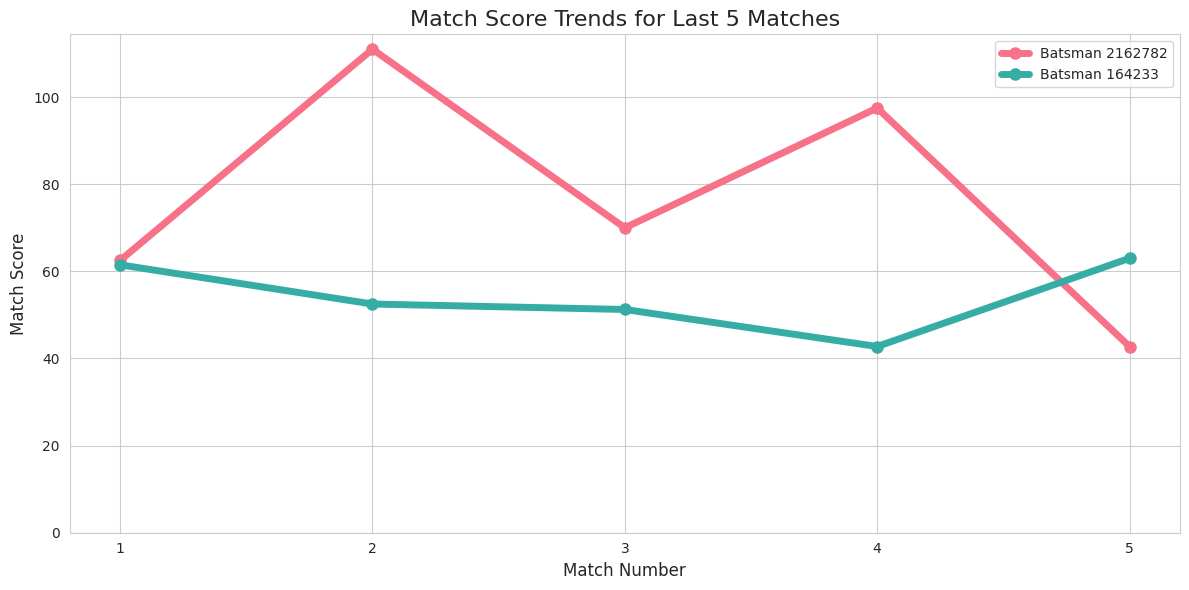

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_batsmen_trends(batsman_df, batsman_ids, n_matches=5):
    # Set up the plot style
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Create a color palette for the lines
    colors = sns.color_palette("husl", n_colors=len(batsman_ids))

    for i, batsman_id in enumerate(batsman_ids):
        # Get the last n matches for the batsman
        batsman_data = batsman_df[batsman_df['batsman_id'] == batsman_id].sort_values('match_dt', ascending=False)
        last_n_matches = batsman_data.head(n_matches)[::-1]  # Reverse to plot chronologically

        # Plot the trend line
        plt.plot(range(1, len(last_n_matches) + 1), last_n_matches['match_score'],
                 marker='o', linestyle='-', linewidth=5, markersize=8,
                 color=colors[i], label=f'Batsman {batsman_id}')

    plt.title(f"Match Score Trends for Last {n_matches} Matches", fontsize=16)
    plt.xlabel("Match Number", fontsize=12)
    plt.ylabel("Match Score", fontsize=12)
    plt.legend(fontsize=10)
    plt.xticks(range(1, n_matches + 1))

    # Adjust y-axis to start from 0
    plt.ylim(bottom=0)

    plt.tight_layout()
    plt.show()

# Example usage:
batsman_ids_to_compare = [2162782, 164233]  # Replace with actual batsman IDs you want to compare
plot_batsmen_trends(processed_batsman_df, batsman_ids_to_compare)